In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from PIL import Image

In [3]:
def prepare_dataset(data_dir, img_height=224, img_width=224, batch_size=32):
    def validate_images(directory):
        valid_formats = {'.jpg', '.jpeg', '.png', '.bmp'}
        invalid_files = []

        for root, _, files in os.walk(directory):
            for filename in files:
                file_path = os.path.join(root, filename)
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext not in valid_formats:
                    invalid_files.append(file_path)
                else:
                    try:
                        with Image.open(file_path) as img:
                            img.verify()
                    except Exception as e:
                        invalid_files.append(f"{file_path}: {str(e)}")

        if invalid_files:
            print("Warning: Ditemukan file yang tidak valid atau rusak:")
            for file in invalid_files:
                print(f"- {file}")

    print("Memvalidasi dataset...")
    validate_images(data_dir)

    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    print("Memuat dataset training...")
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    print("Memuat dataset validasi...")
    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    print(f"Jumlah kelas yang ditemukan: {len(train_generator.class_indices)}")
    print("Nama kelas:", train_generator.class_indices)
    print(f"Total gambar training: {train_generator.samples}")
    print(f"Total gambar validasi: {validation_generator.samples}")

    return train_generator, validation_generator

In [4]:
def create_model(num_classes, img_height=224, img_width=224):
    print("Membuat model EfficientNetV2...")
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )

    base_model.trainable = False

    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetV2_Electronic')
    return model, base_model


In [5]:
def unfreeze_model(model, base_model):
    print("Unfreezing layers untuk fine-tuning...")
    base_model.trainable = True

    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    return model

In [7]:
def train_model(model, train_generator, validation_generator, epochs=50):
    initial_epochs = int(epochs * 0.4)
    fine_tuning_epochs = epochs - initial_epochs

    print("Kompilasi model...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    print(f"\nPhase 1: Training dengan frozen base model ({initial_epochs} epochs)...")
    history1 = model.fit(
        train_generator,
        epochs=initial_epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    print(f"\nPhase 2: Fine-tuning model ({fine_tuning_epochs} epochs)...")
    model = unfreeze_model(model, base_model)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history2 = model.fit(
        train_generator,
        epochs=fine_tuning_epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    total_history = {}
    for key in history1.history:
        total_history[key] = history1.history[key] + history2.history[key]

    return total_history

Memulai proses training...
1. Mounting Google Drive...

2. Mempersiapkan dataset...
Memvalidasi dataset...
Memuat dataset training...
Found 322 images belonging to 10 classes.
Memuat dataset validasi...
Found 79 images belonging to 10 classes.
Jumlah kelas yang ditemukan: 10
Nama kelas: {'BreadBoard': 0, 'IntegratedCircuit': 1, 'Kapasitor': 2, 'Resistor': 3, 'connector': 4, 'dioda': 5, 'pcb': 6, 'sensor': 7, 'swicth': 8, 'transistor': 9}
Total gambar training: 322
Total gambar validasi: 79

3. Membuat dan menginisialisasi model...
Membuat model EfficientNetV2...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Arsitektur Model:


Model: "EfficientNetV2_Electronic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,255,962 (23.86 MB)

 Trainable params: 333,578 (1.27 MB)

 Non-trainable params: 5,922,384 (22.59 MB)


4. Memulai proses training...
Kompilasi model...

Phase 1: Training dengan frozen base model (20 epochs)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3041 - loss: 2.5248

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.3215 - loss: 2.4555 - val_accuracy: 0.8228 - val_loss: 0.9539 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8371 - loss: 0.5079 - val_accuracy: 0.9367 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9206 - loss: 0.2142 - val_accuracy: 0.9241 - val_loss: 0.3690 - learning_rate: 0.0010
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9522 - loss: 0.1280 - val_accuracy: 0.9367 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9709 - loss: 0.0910 - val_accuracy: 0.9494 - val_loss: 0.2615 - learning_rate: 0.0010
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9819 - loss: 0.0762 - val_accuracy: 1.0000 - val_loss: 0.1929 - learning_rate: 0.0010
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9899 - loss: 0.0334 - val_accuracy: 0.9873 - va

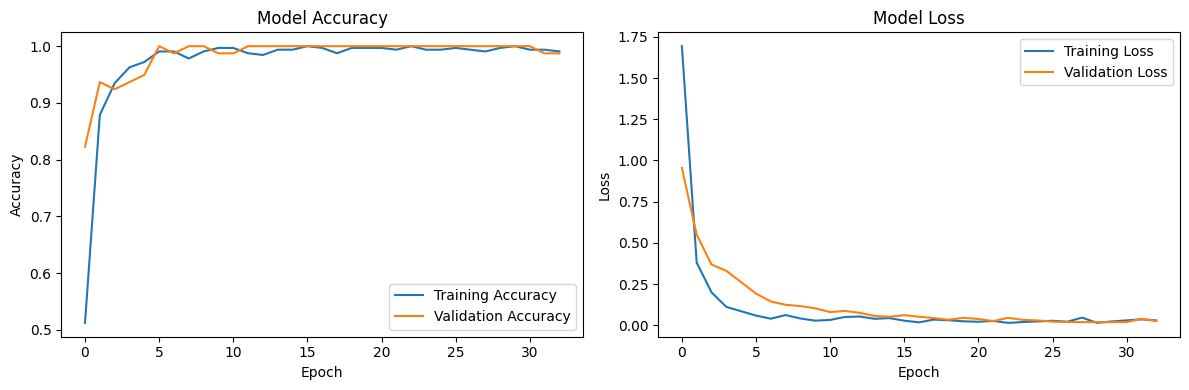


6. Menyimpan model...
Model berhasil disimpan di: /content/drive/MyDrive/models/electronic_component_classifier_efficientnet.keras

Proses training selesai!


In [9]:
def plot_training_results(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Memulai proses training...")
print("1. Mounting Google Drive...")

try:
    DATA_DIR = '/content/drive/MyDrive/dataset_elektronik'
    MODEL_SAVE_PATH = '/content/drive/MyDrive/models/electronic_component_classifier_efficientnet.keras'

    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    BATCH_SIZE = 32
    EPOCHS = 50

    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    print("\n2. Mempersiapkan dataset...")
    train_generator, validation_generator = prepare_dataset(
        DATA_DIR,
        IMG_HEIGHT,
        IMG_WIDTH,
        BATCH_SIZE
    )

    print("\n3. Membuat dan menginisialisasi model...")
    model, base_model = create_model(
        num_classes=len(train_generator.class_indices),
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH
    )

    print("\nArsitektur Model:")
    model.summary()

    print("\n4. Memulai proses training...")
    history = train_model(
        model,
        train_generator,
        validation_generator,
        EPOCHS
    )

    print("\n5. Memvisualisasikan hasil training...")
    plot_training_results(history)

    print("\n6. Menyimpan model...")
    model.save(MODEL_SAVE_PATH)
    print(f"Model berhasil disimpan di: {MODEL_SAVE_PATH}")

    print("\nProses training selesai!")

except Exception as e:
    print(f"\nError terjadi: {str(e)}")
    print("Mohon periksa error di atas dan pastikan semua path sudah benar.")

Program Testing Model Klasifikasi Komponen Elektronik
--------------------------------------------------

Opsi:
1. Upload gambar untuk diprediksi
2. Keluar

Pilih opsi (1/2): 1

Silakan pilih file gambar dari komputer Anda...


Saving electrolytic-capacitors-68uf-450v-500x500.png to electrolytic-capacitors-68uf-450v-500x500.png

Gambar diupload: electrolytic-capacitors-68uf-450v-500x500.png
Memuat model...
Memproses gambar...
Melakukan prediksi...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


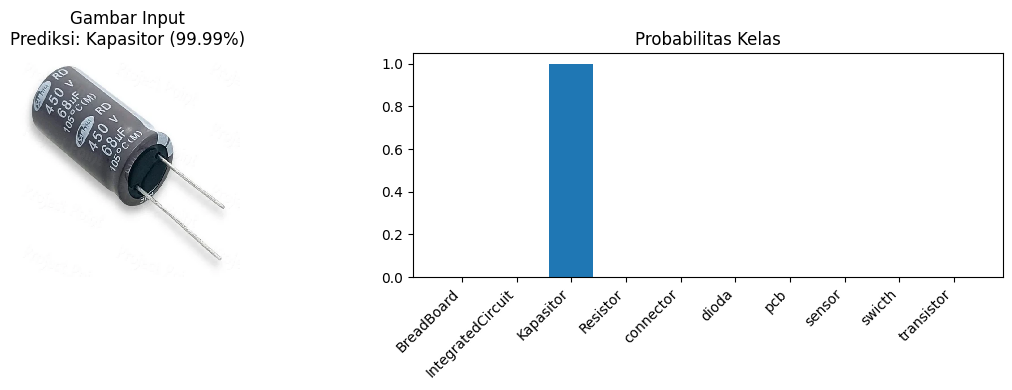


Hasil Prediksi:
Kelas: Kapasitor
Confidence: 99.99%

Top 3 Prediksi:
Kapasitor: 99.99%
Resistor: 0.00%
sensor: 0.00%

Opsi:
1. Upload gambar untuk diprediksi
2. Keluar

Pilih opsi (1/2): 1

Silakan pilih file gambar dari komputer Anda...


Saving images (4).jfif to images (4).jfif

Gambar diupload: images (4).jfif
Memuat model...
Memproses gambar...
Melakukan prediksi...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


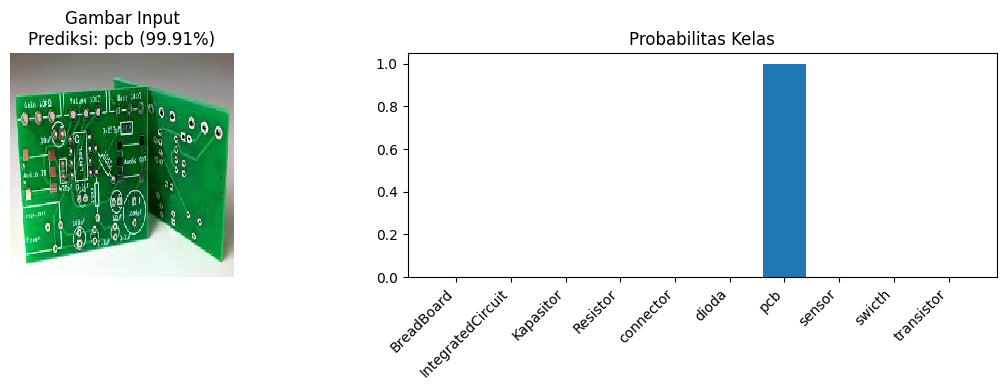


Hasil Prediksi:
Kelas: pcb
Confidence: 99.91%

Top 3 Prediksi:
pcb: 99.91%
sensor: 0.06%
BreadBoard: 0.01%

Opsi:
1. Upload gambar untuk diprediksi
2. Keluar

Pilih opsi (1/2): 1

Silakan pilih file gambar dari komputer Anda...


Saving nirewHbvyLphCtPUoRfGRyWn015ZxKXlHz6t190I.png to nirewHbvyLphCtPUoRfGRyWn015ZxKXlHz6t190I.png

Gambar diupload: nirewHbvyLphCtPUoRfGRyWn015ZxKXlHz6t190I.png
Memuat model...
Memproses gambar...
Melakukan prediksi...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


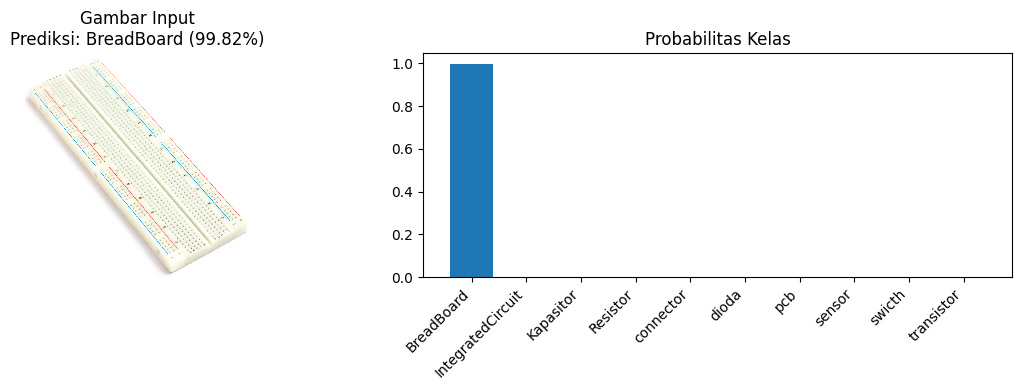


Hasil Prediksi:
Kelas: BreadBoard
Confidence: 99.82%

Top 3 Prediksi:
BreadBoard: 99.82%
pcb: 0.08%
dioda: 0.04%

Opsi:
1. Upload gambar untuk diprediksi
2. Keluar

Pilih opsi (1/2): 1

Silakan pilih file gambar dari komputer Anda...


Saving 51dc6e21ce395f0807000000.png to 51dc6e21ce395f0807000000.png

Gambar diupload: 51dc6e21ce395f0807000000.png
Memuat model...
Memproses gambar...
Melakukan prediksi...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


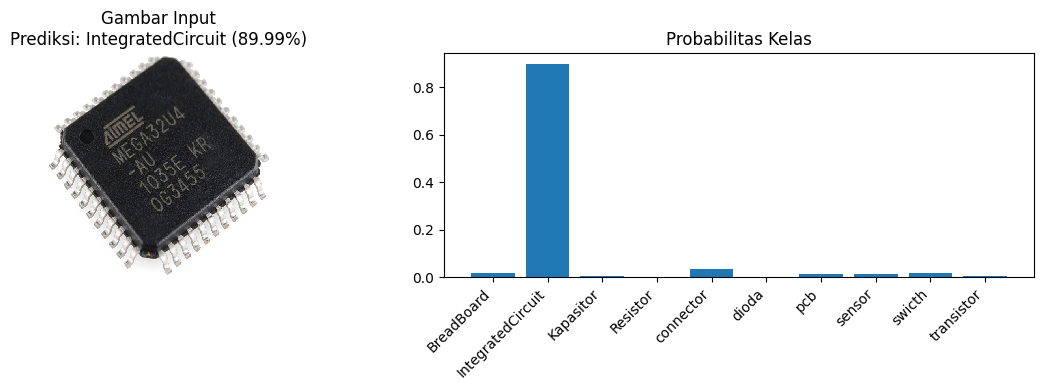


Hasil Prediksi:
Kelas: IntegratedCircuit
Confidence: 89.99%

Top 3 Prediksi:
IntegratedCircuit: 89.99%
connector: 3.41%
BreadBoard: 1.64%

Opsi:
1. Upload gambar untuk diprediksi
2. Keluar

Pilih opsi (1/2): 2

Program selesai!


In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os
import tempfile

def predict_image(model_path, image_path, class_names):
    """
    Melakukan prediksi pada gambar menggunakan model yang telah dilatih
    """
    try:
        # Muat model
        print("Memuat model...")
        model = load_model(model_path)

        # Muat dan proses gambar
        print("Memproses gambar...")
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)

        # Lakukan prediksi
        print("Melakukan prediksi...")
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_index]

        # Dapatkan nama kelas
        class_names_list = list(class_names.keys())
        predicted_class = class_names_list[predicted_class_index]

        # Tampilkan hasil
        plt.figure(figsize=(12, 4))

        # Plot gambar asli
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Gambar Input\nPrediksi: {predicted_class} ({confidence:.2%})')
        plt.axis('off')

        # Plot hasil prediksi
        plt.subplot(1, 2, 2)
        plt.bar(class_names_list, predictions[0])
        plt.xticks(rotation=45, ha='right')
        plt.title('Probabilitas Kelas')

        plt.tight_layout()
        plt.show()

        print(f"\nHasil Prediksi:")
        print(f"Kelas: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")

        # Tampilkan top 3 prediksi
        top_3_indices = np.argsort(predictions[0])[-3:][::-1]
        print("\nTop 3 Prediksi:")
        for idx in top_3_indices:
            class_name = class_names_list[idx]
            confidence = predictions[0][idx]
            print(f"{class_name}: {confidence:.2%}")

    except Exception as e:
        print(f"Error saat melakukan prediksi: {str(e)}")

def test_model_interactive():
    """
    Fungsi interaktif untuk menguji model dengan upload file di Colab
    """
    # Path ke model
    MODEL_PATH = '/content/drive/MyDrive/models/electronic_component_classifier_efficientnet.keras'

    # Definisikan nama-nama kelas
    class_names = {
        'BreadBoard': 0,
        'IntegratedCircuit': 1,
        'Kapasitor': 2,
        'Resistor': 3,
        'connector': 4,
        'dioda': 5,
        'pcb': 6,
        'sensor': 7,
        'swicth': 8,
        'transistor': 9
    }

    print("Program Testing Model Klasifikasi Komponen Elektronik")
    print("--------------------------------------------------")

    while True:
        print("\nOpsi:")
        print("1. Upload gambar untuk diprediksi")
        print("2. Keluar")

        choice = input("\nPilih opsi (1/2): ")

        if choice == '2':
            print("\nProgram selesai!")
            break
        elif choice == '1':
            try:
                print("\nSilakan pilih file gambar dari komputer Anda...")
                uploaded = files.upload()

                if uploaded:
                    # Ambil nama file yang diupload
                    image_path = next(iter(uploaded))
                    print(f"\nGambar diupload: {image_path}")

                    # Prediksi gambar
                    predict_image(MODEL_PATH, image_path, class_names)
                else:
                    print("\nTidak ada gambar yang diupload")

            except Exception as e:
                print(f"Error saat upload file: {str(e)}")
        else:
            print("\nOpsi tidak valid. Silakan pilih 1 atau 2.")

# Jalankan testing
if __name__ == "__main__":
    test_model_interactive()